In [1]:
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
from pprint import pprint
from numpy import sin, cos, pi
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from tensorflow import keras
from pyomo.gdp import *
from scipy.spatial import ConvexHull
import os
import pickle
from tensorflow import keras
import tensorflow.keras.backend as kb

2 Physical GPUs, 2 Logical GPUs


2022-02-23 11:41:16.135153: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 11:41:16.931599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5077 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:bd:00.0, compute capability: 7.5
2022-02-23 11:41:16.932171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6136 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:91:00.0, compute capability: 6.1


In [2]:
from nnreplayer.utils.options import Options
from nnreplayer.utils.utils import constraints_class
from nnreplayer.repair.perform_repair import perform_repair


2 Physical GPUs, 2 Logical GPUs


# Introduction

This demo is for repairing a neural network that repairs the affine transform neural network example to follow a certain constraint. We perform the folowing operations here:

1) Load the neural network and samples that have both normal and adverserial examples.
2) Define the constraints
3) Define the layer to repair and run the repair

# Load Neural Network

In [3]:

#define costum loss function
def keras_SSE_costum(y_actual, y_predicted):
    err = y_actual - y_predicted
    loss_value = kb.sum(kb.square(err))
    return loss_value

model_orig = keras.models.load_model(os.getcwd()+'/affine_transform_original_model', compile= False)





with open(os.getcwd() + "/affine_io_dataset.pickle", "rb") as data:
    x_train, y_train, x_test, y_test = pickle.load(data)



# Define the Architecture and Cost-Function

In [4]:

num_input = 3
num_output = 3
num_hidden_0 = 20
num_hidden_1 = 10
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]

def squared_sum(x, y):
    m,n = np.array(x).shape
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum
    


# Define the Constraint for the form $ Ax<b$

In [5]:
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix
inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]

b = np.array([b]).T

constraint_inside = constraints_class("inside", A, b)
output_constraint_list = [constraint_inside]


# Run the Repair Problem

In [6]:

layer_to_repair = 3
train_dataset = (x_train, y_train)
weight_slack = 100
time_limit = 3600
mip_gap = 0.05
options = Options('gdp.bigm', 'gurobi', "python", "keras", weight_slack, time_limit, mip_gap)

results = perform_repair(layer_to_repair, model_orig, architecture, output_constraint_list, squared_sum, train_dataset, options)


y_new_train = results.new_model.predict(x_train)
y_new_test = results.new_model.predict(x_test)


y_train_original = model_orig.predict(x_train)
y_test_original = model_orig.predict(x_test)

print("weight_error: {}".format(results.weight_error))
print("bias_error: {}".format(results.bias_error))



[array([[-0.17959996, -0.11999024,  0.5953039 ,  0.19763128,  0.20654614,
         0.06330217, -0.3447489 ,  0.55381274,  0.46533778,  0.1307468 ,
         0.07473419,  0.2924618 ,  0.53518814,  0.37299043, -0.29410517,
        -0.04273028,  0.3668488 , -0.26593745,  0.22071141,  0.32524565],
       [-0.22352184,  0.03517943,  0.26840004,  0.04695475, -0.24388406,
         0.43485782, -0.2140405 ,  0.49168321, -0.06397917,  0.07533164,
        -0.38369158, -0.15072013, -0.09949924, -0.19152433, -0.29158103,
        -0.23025984,  0.13394217,  0.19789995, -0.33808744, -0.30945495],
       [ 0.31531888, -0.14817142,  0.5214147 ,  0.08525436, -0.18778664,
        -0.414541  ,  0.35841855, -0.09758534, -0.33297914,  0.37064105,
        -0.39380148,  0.04708139, -0.2781865 ,  0.19522405, -0.48506114,
         0.31207636, -0.14323589,  0.3207405 , -0.00938816,  0.5533868 ]],
      dtype=float32), array([ 0.        ,  0.        ,  0.13294145, -0.05633564, -0.04313822,
       -0.16083421,  0.  

Thread count was 20 (of 20 available processors)

Solution count 1: 9.82572 

Optimal solution found (tolerance 2.00e-02)
Best objective 9.825719777306e+00, best bound 9.825719777305e+00, gap 0.0000%
Set parameter LogFile to value ""
dw : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.8717105093746779 :   100 : False : False : NonNegativeReals
None
weight_error: 0.8717105076849596
bias_error: 0.871710504912337


# Plot the Outputs

In [7]:
def plot_model(model, x_true, y_true, arg):
    y_predict = model.predict(x_true)
    
    ## training output
    plt.plot(y_true[:,0], y_true[:,1], 'ro', label='Original Samples')

    ## predicted output
    plt.plot(y_predict[:,0], y_predict[:,1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict



(210, 3)


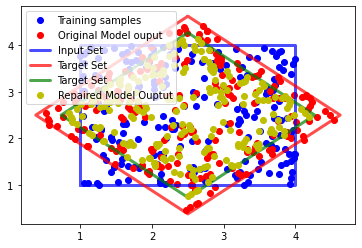

(210, 3)


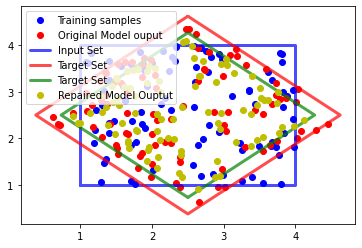

2022-02-23 11:05:35.300947: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: repaired_affine_transform_layer3/assets


In [16]:
num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy
x_poly3, y_poly3 = poly3.exterior.xy
print(x_train.shape)
plt.plot(x_train[:,0], x_train[:,1], 'bo', label='Training samples')
plt.plot(y_train_original[:,0], y_train_original[:,1], 'ro', label='Original Model ouput')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_train[:,0], y_new_train[:,1], 'yo', label='Repaired Model Ouptut')
plt.legend(loc="upper left")
plt.show()

num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy
x_poly3, y_poly3 = poly3.exterior.xy
print(x_train.shape)
plt.plot(x_test[:,0], x_test[:,1], 'bo', label='Training samples')
plt.plot(y_test_original[:,0], y_test_original[:,1], 'ro', label='Original Model ouput')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_test[:,0], y_new_test[:,1], 'yo', label='Repaired Model Ouptut')
plt.legend(loc="upper left")
plt.show()

results.new_model.save("repaired_affine_transform_layer{}".format(layer_to_repair), '/home/daittan/NN-Repair/NN-Repair/')
